## LangGraph로 에이전트 시스템 만들기
프롬프트를 만들어 주는 에이전트 만들기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
from typing import List, Annotated, Literal, TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from pydantic import BaseModel

### 정보 수집 함수

In [3]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])


def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

### 프롬프트 작성 함수

In [4]:
# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
            print(tool_call)
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

### 프롬프트 구성에 필요한 정보 수집 완료를 위한 edge 로직

In [5]:
def get_state(state) -> Literal["prompt", "info", "__end__"]:
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "prompt"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

### 그래프 만들기

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)

# 엣지 및 조건부 엣지 추가
workflow.add_conditional_edges("info", get_state)
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)

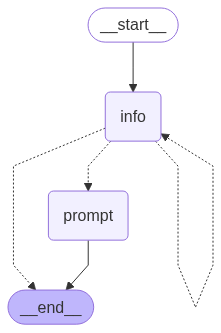

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

그래프 실행

In [8]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

================================== Ai Message ==================================

시를 작성하는 프롬프트를 만들기 위해 몇 가지 정보를 더 필요로 합니다. 다음 질문에 답해 주실 수 있나요?

1. 시의 목적은 무엇인가요? (예: 감정 표현, 특정 주제에 대한 탐구 등)
2. 프롬프트 템플릿에 어떤 변수를 포함할 건가요? (예: 주제, 감정, 특정 단어 등)
3. 출력에서 피해야 할 제약 조건이 있나요? (예: 특정 단어 사용 금지, 특정 형식 준수 등)
4. 출력이 반드시 따라야 할 요구 사항이 있나요? (예: 특정 길이, 특정 스타일 등)

이 정보를 제공해 주시면, 원하는 프롬프트를 만드는 데 도움이 될 것입니다!
================================== Ai Message ==================================

감정에 알맞은 시를 작성하는 프롬프트를 만들기 위해 추가적인 정보를 요청드립니다.

1. 출력에서 피해야 할 제약 조건이 있나요? (예: 특정 단어 사용 금지, 특정 형식 준수 등)
2. 출력이 반드시 따라야 할 요구 사항이 있나요? (예: 특정 길이, 특정 스타일 등)

이 두 가지 정보를 제공해 주시면, 프롬프트를 완성할 수 있습니다!
================================== Ai Message ==================================
Tool Calls:
  PromptInstructions (call_t8EHokiOmsmCDu7rgP2TwTR6)
 Call ID: call_t8EHokiOmsmCDu7rgP2TwTR6
  Args:
    objective: 사용자에게 입력받은 감정에 알맞은 시를 작성한다.
    variables: ['감정']
    constraints: []
    requirements: ['시의 형식은 자유롭게 작성한다.', '감정에 맞는 표현을 사용한다.']
{